<a href="https://colab.research.google.com/github/crunchdomo/llm_conversation/blob/main/recipe_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

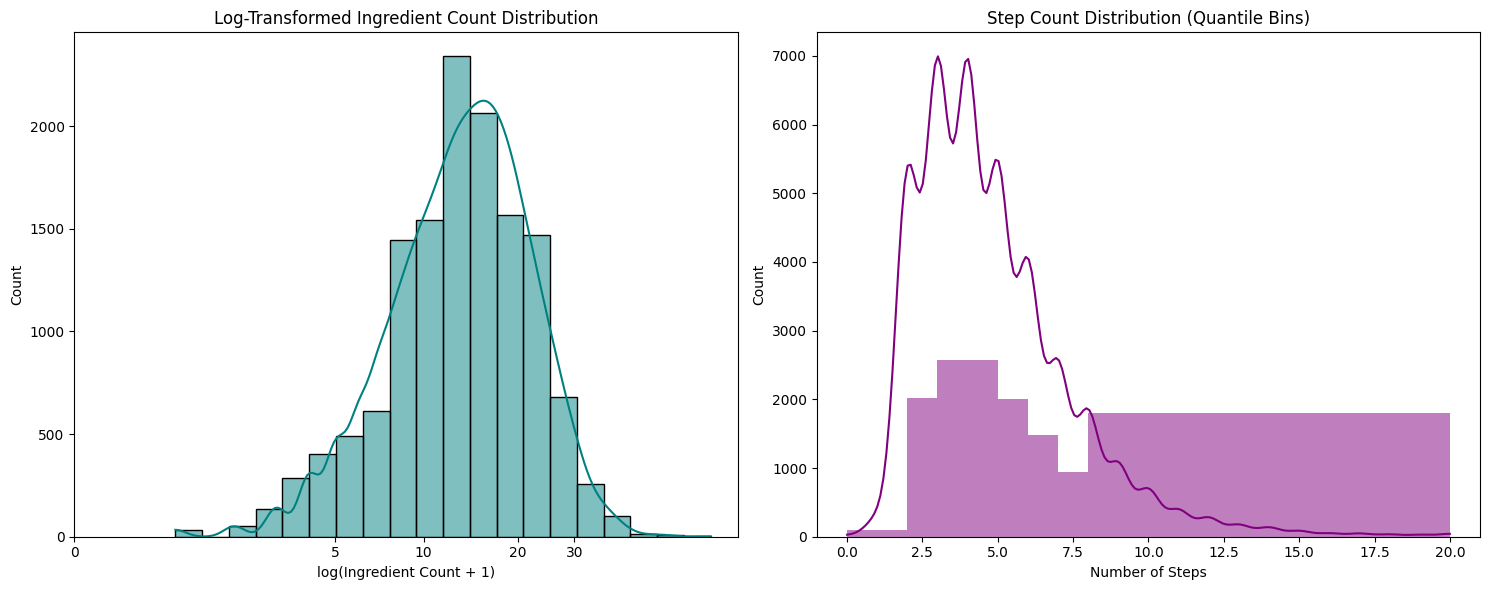

Ingredient Count Statistics:
count    13501.000000
mean        14.684172
std          7.185373
min          1.000000
25%          9.000000
50%         14.000000
75%         19.000000
max         78.000000
Name: ingredient_count, dtype: float64

Step Count Statistics:
count    13501.000000
mean         4.848604
std          2.599238
min          0.000000
25%          3.000000
50%          4.000000
75%          6.000000
max         20.000000
Name: step_count, dtype: float64

=== Recipe: Miso-Butter Roast Chicken With Acorn Squash Panzanella ===
Computed Step Count: 10

Instructions:
Pat chicken dry with paper towels, season all over with 2 tsp. salt, and tie legs together with kitchen twine. Let sit at room temperature 1 hour.
Meanwhile, halve squash and scoop out seeds. Run a vegetable peeler along ridges of squash halves to remove skin. Cut each half into ½"-thick wedges; arrange on a rimmed baking sheet.
Combine sage, rosemary, and 6 Tbsp. melted butter in a large bowl; pour half of m

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

# Load data with proper parsing
df = pd.read_csv('13k-recipes.csv', index_col=0)

# Enhanced ingredient normalization
def normalize_ingredient(ingredient):
    """Clean and standardize ingredient names"""
    ingredient = re.sub(r'\b\d+[½¼¾]?[\s-]*[\d½¼¾]*\s*[a-z]*\.?\s*', '', ingredient)  # Remove quantities
    ingredient = re.sub(r'\b(cup|tsp|tbsp|lb|oz|ounce|clove|slice)s?\b', '', ingredient, flags=re.IGNORECASE)
    ingredient = re.sub(r'[\(\)\[\]\'\"]', '', ingredient)
    ingredient = re.sub(r'\b(?:divided|optional|chopped|diced|minced|fresh|dried)\b', '', ingredient, flags=re.IGNORECASE)
    return ingredient.strip().lower()

def parse_ingredients(ing_str):
    try:
        if pd.isna(ing_str) or len(ing_str) < 3:
            return []
        ingredients = [i.strip() for i in ing_str[1:-1].split(',')]
        return [normalize_ingredient(i) for i in ingredients if i.strip()]
    except Exception as e:
        print(f"Error parsing ingredients: {e}")
        return []

df['ingredient_list'] = df['Cleaned_Ingredients'].apply(parse_ingredients)
df['ingredient_count'] = df['ingredient_list'].apply(len)

# Robust step counting with multiple fallbacks
def count_steps(instructions):
    if pd.isna(instructions):
        return 0

    text = str(instructions).strip()

    # Attempt 1: Numbered steps detection
    numbered_steps = re.findall(r'(?:^|\n)\s*(?:\d+[\.\)]|Step\s*\d+)', text)
    if len(numbered_steps) > 1:
        return min(len(numbered_steps), 20)

    # Attempt 2: Paragraph detection (any newline combination)
    paragraphs = [p.strip() for p in re.split(r'\n+', text) if p.strip()]
    if len(paragraphs) > 1:
        return min(len(paragraphs), 20)

    # Attempt 3: Sentence splitting with minimum length
    sentences = [s.strip() for s in re.split(r'[.!?](?=\s|$)', text) if len(s.strip()) > 20]
    return min(len(sentences), 20) if sentences else 1

df['step_count'] = df['Instructions'].apply(count_steps)

# Create visualization with improved scaling
plt.figure(figsize=(15, 6))

# Ingredient distribution with log scale
plt.subplot(1, 2, 1)
sns.histplot(np.log1p(df['ingredient_count']), bins=20, color='teal', kde=True)
plt.title('Log-Transformed Ingredient Count Distribution')
plt.xlabel('log(Ingredient Count + 1)')
plt.xticks(np.log1p([0, 5, 10, 20, 30]), [0, 5, 10, 20, 30])

# Step distribution with quantile-based bins
plt.subplot(1, 2, 2)
step_bins = np.quantile(df['step_count'], np.linspace(0, 1, 11))
sns.histplot(df['step_count'], bins=step_bins, color='purple', kde=True)
plt.title('Step Count Distribution (Quantile Bins)')
plt.xlabel('Number of Steps')

plt.tight_layout()
plt.show()

# Print statistics
print("Ingredient Count Statistics:")
print(df['ingredient_count'].describe())
print("\nStep Count Statistics:")
print(df['step_count'].describe())

def print_recipe_steps(idx):
    """Print step counting details for a specific recipe"""
    recipe = df.iloc[idx]
    print(f"\n=== Recipe: {recipe['Title']} ===")
    print(f"Computed Step Count: {recipe['step_count']}")
    print("\nInstructions:")
    print(recipe['Instructions'])

# Verify 3 sample recipes
sample_indices = [0, 10, 100]  # Adjust these indices based on your data
for idx in sample_indices:
    print_recipe_steps(idx)
    print("\n" + "="*50 + "\n")

# Alternative: Find recipes using different counting methods
def detect_counting_method(text):
    text = str(text).strip()
    if re.search(r'(?:^|\n)\s*\d+[\.\)]', text):
        return "numbered"
    if re.search(r'\n\s*\n', text):
        return "paragraphs"
    return "sentences"

df['counting_method'] = df['Instructions'].apply(detect_counting_method)
print("\nCounting Method Distribution:")
print(df['counting_method'].value_counts())
